<a href="https://colab.research.google.com/github/cheul0518/DeepLearning/blob/main/MXNet/MXNet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MXNet Crashcourse

In [2]:
#@title Install MXNet
!pip install -U mxnet

     |████████████████████████████████| 46.9 MB 42 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


### Basic neural network

In [ ]:
from mxnet import nd
from mxnet.gluon import nn

layer = nn.Dense(2) # Not necessary to specify the argument in_units = 4.
                    # The system'll automatically infer it.
print('The network structure is\n', layer) # Print the network structure
# Acutal initialization occurs after the first feed.
layer.initialize() # default initialization = uniform random distribution [-0.7, 0.7]
x = nd.random.uniform(-1,1,(3,4))
layer(x)
print(layer.weight.data(),'\n')

# LeNet
net = nn.Sequential()
net.add(# Similar to Dense, it is not necessasry to specify that input channels
        # by the argument 'in_units', which will be automatically inferred
        # in the first forward pass. Also, we applay a relu activation on the 
        # output. In addition, we can use a tuple to specify a non-square
        # kernel size, such as 'kernel_size=(2,4)'
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        # One can also use a tuple to specify non-symmetric pool and stride sizes
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # The dense layer will automatically reshape the 4-D output of last 
        # max pooling layer into the 2-D shape: (x.shape[0], x.size/x.shape[0])
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10)
        )
net.initialize()
# Input shape is (batch_size, color_channels, height, width)
x = nd.random.uniform(shape=(4,1,28,28))
y = net(x)
print(net)
print(y.shape)
print(net[0].weight.data().shape, net[2].weight.data().shape, net[5].bias.data().shape,'\n')

class MixMLP(nn.Block):
      def __init__(self, **kwargs):
          # Run `nn.Block`'s init method
          super(MixMLP, self).__init__(**kwargs)
          self.blk = nn.Sequential()
          self.blk.add(nn.Dense(3, activation='relu'),
                       nn.Dense(4, activation='relu'))
          self.dense = nn.Dense(5)
      def forward(self, x):
          y = nd.relu(self.blk(x))
          print(y,'\n')
          return self.dense(y)
net = MixMLP()
net.initialize()
x = nd.random.uniform(shape=(2,2))
y = net(x)
print(net)
print(net.blk[1].weight.data().shape, net.dense.weight.data().shape)

The network structure is
 Dense(None -> 2, linear)

[[ 0.05038179  0.03062621  0.02371399  0.05066947]
 [ 0.06981572 -0.04736222  0.0623387   0.06158083]]
<NDArray 2x4 @cpu(0)> 

Sequential(
  (0): Conv2D(1 -> 6, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(6 -> 16, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Dense(400 -> 120, Activation(relu))
  (5): Dense(120 -> 84, Activation(relu))
  (6): Dense(84 -> 10, linear)
)
(4, 10)
(6, 1, 5, 5) (16, 6, 3, 3) (84,) 


[[0.         0.         0.00293104 0.        ]
 [0.         0.         0.00376435 0.        ]]
<NDArray 2x4 @cpu(0)> 

MixMLP(
  (blk): Sequential(
    (0): Dense(2 -> 3, Activation(relu))
    (1): Dense(3 -> 4, Activation(relu))
  )
  (dense): D

### Automatic differentiation with autograd

In [ ]:
from mxnet import nd
from mxnet import autograd

x = nd.array([[1,2],[3,4]])

# Mark a variable for the partial derivation and store a gradient
x.attach_grad()

# Define the function y = f(x)
with autograd.record():
    y = 2 * x * x

# Back propagation. 
# y has more than one entry -> y.backward()'s equivalent to y.sum().backward()
y.backward()
print(x.grad)

def f(a):
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() >= 0:
        c = b[0]
    else:
        c = b[1]
    return c

a = nd.random.uniform(shape=2)
a.attach_grad()
with autograd.record():
    c = f(a)
c.backward()
print(a, [a.grad, c/a])


[[ 4.  8.]
 [12. 16.]]
<NDArray 2x2 @cpu(0)>

[0.7584295  0.11823815]
<NDArray 2 @cpu(0)> [
[2048.    0.]
<NDArray 2 @cpu(0)>, 
[ 2048.    13136.738]
<NDArray 2 @cpu(0)>]


### Train the neural network

X shape: (28, 28, 1) , X dtype: <class 'numpy.uint8'> , y: 2


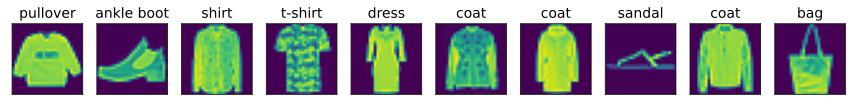

(256, 1, 28, 28) (256,)
Epoch 0: loss 1.542, train_acc 0.457, test_acc 0.604, in 19.6 sec
Epoch 1: loss 1.083, train_acc 0.615, test_acc 0.653, in 20.5 sec
Epoch 2: loss 0.890, train_acc 0.658, test_acc 0.680, in 20.0 sec
Epoch 3: loss 0.834, train_acc 0.676, test_acc 0.688, in 19.4 sec
Epoch 4: loss 0.802, train_acc 0.686, test_acc 0.692, in 20.5 sec
Epoch 5: loss 0.781, train_acc 0.693, test_acc 0.694, in 20.5 sec
Epoch 6: loss 0.765, train_acc 0.698, test_acc 0.703, in 20.8 sec
Epoch 7: loss 0.752, train_acc 0.703, test_acc 0.703, in 19.9 sec
Epoch 8: loss 0.741, train_acc 0.706, test_acc 0.709, in 19.2 sec
Epoch 9: loss 0.731, train_acc 0.708, test_acc 0.708, in 20.4 sec


In [16]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
print('X shape:', X.shape, ', X dtype:', X.dtype, ', y:', y)

text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
               'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, axs = plt.subplots(1, X.shape[0], figsize=(15,15)) # One row, 10 columns
for ax, x, yi in zip(axs, X, y):
    # 3D -> 2D by removing the last channel dimiension
    ax.imshow(x.reshape((28,28)).asnumpy())
    ax = ax.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Create transform format for the dataset
transformer = transforms.Compose([
                                 # From (height, width, channel) 
                                 # To (channel, height, width) 
                                 transforms.ToTensor(), 
                                 # mean = 0.13, std = 0.31
                                 transforms.Normalize(0.13, 0.31)
                                ])
# Apply transform to the first element of the data pair, namely the images.
mnist_train = mnist_train.transform_first(transformer)

# Get a randomized batch of examples, using gluon.data.DataLoader.
batch_size = 256
# Set 4 to num_workers to process data in parallel.
train_data = gluon.data.DataLoader(dataset=mnist_train, batch_size=batch_size, 
                                   shuffle=True, num_workers=4)
# Check the returned train_data
for data, label in train_data:
    print(data.shape, label.shape)
    break

mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(mnist_valid.transform_first(transformer), 
                                   batch_size, num_workers=4)

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10, activation='relu'))
net.initialize(init=init.Xavier())
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
# collect_params: returns a parameterDict 
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

def acc(output, label):
    '''Output: (batch, num_output) float32 ndarray, 
    label: (batch,) int32 ndarray'''
    return (output.argmax(axis=1)==label.astype('float32')).mean().asscalar()

for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)
    print("Epoch %d: loss %.3f, train_acc %.3f, test_acc %.3f, in %.1f sec"%(
          epoch,train_loss/len(train_data), train_acc/len(train_data), 
          valid_acc/len(valid_data), time.time()-tic))

net.save_parameters('net.params')

### Predict with a pre-trained model

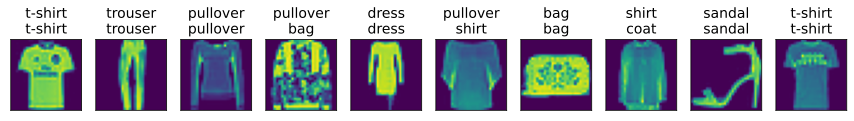

In [ ]:
from mxnet import nd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt

net = nn.Sequential()
net.add(nn.Conv2D(6,5, activation='relu'),
        nn.MaxPool2D(strides=2),
        nn.Conv2D(16,3, activation='relu'),
        nn.MaxPool2D(strides=2),
        nn.Flatten(),
        nn.Dense(120, 'relu'),
        nn.Dense(84, 'relu'),
        nn.Dense(10))
# Load all parameters saved into a file
net.load_parameters('net.params')

transformer = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.13, 0.31)])
mnist_valid = datasets.FashionMNIST(train=False)
X,y = mnist_valid[:10]
preds=[]
for x in X:
    # Inserts a new axis of size 1 into the array shape
    # axis argument is the position where a new axis is to be inserted.
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

_, axs = plt.subplots(1, len(X), figsize=(15,15))
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
               'shirt', 'sneaker', 'bag', 'ankle boot']
display.set_matplotlib_formats('svg')
for ax, x, yi, pyi in zip(axs, X, y, preds):
    ax.imshow(x.reshape((28,28)).asnumpy())
    ax = ax.axes
    ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

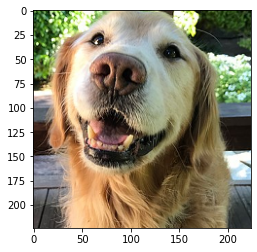

(1, 1000)
With prob = 0.98323, it contains golden retriever
With prob = 0.00729, it contains English setter
With prob = 0.00297, it contains Irish setter, red setter
With prob = 0.00224, it contains cocker spaniel, English cocker spaniel, cocker
With prob = 0.00147, it contains Labrador retriever


In [28]:
from mxnet import nd
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.utils import download
from mxnet import image
import matplotlib.pyplot as plt

net = models.resnet50_v2(pretrained=True)
url = 'http://data.mxnet.io/models/imagenet/synset.txt'
fname = download(url)
with open(fname, 'r') as f:
    text_labels = [' '.join(l.split()[1:]) for l in f]

url = 'https://raw.githubusercontent.com/cheul0518/DeepLearning/main/MXNet/img/GoldenRetriever.jpg'
fname = download(url)
x = image.imread(fname)
x = image.resize_short(x, 256) # Resize the short edge into 256 pixes.
x, _ = image.center_crop(x, (224,224)) # center crop to obtain a 224x224 image.
plt.imshow(x.asnumpy())
plt.show()

def transform(data):
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32')/255 - rgb_mean) / rgb_std

prob = net(transform(x)).softmax()
idx = prob.topk(k=5) # Returns the indices of the top k elements in an input array along the given axis
for i in idx[0]:
    i = int(i.asscalar())    
    print('With prob = %.5f, it contains %s'%(prob[0,i].asscalar(), text_labels[i]))

### Use GPUs

In [ ]:
# Check Cuda version for mxnet suffix.
!nvcc --version
!pip uninstall mxnet
!pip install mxnet-cu110

In [27]:
from mxnet import nd, gpu, gluon, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import time

x = nd.ones((3,4), ctx=gpu()) # gpu() = gpu(0) indiating the first GPU
#x.copyto(gpu(1)) # You can use another gpu indexed from 0 to ...
# Caution: print(), asnumpy(), and asscalar() will move data to main memory.
print("x is @ GPU", x)
x = nd.array(x.asnumpy())
print()
print("x is @ CPU(main memory)", x)
x = nd.ones((3,4), ctx=gpu())
y = nd.random.uniform(shape=(3,4), ctx=gpu())
print(x+y) # An operation requires the operands on the same GPU/CPU

net = nn.Sequential()
net.add(nn.Conv2D(6,5,activation='relu'),
        nn.MaxPool2D(2,2),
        nn.Conv2D(16,3,activation='relu'),
        nn.MaxPool2D(2,2),
        nn.Flatten(),
        nn.Dense(120, 'relu'),
        nn.Dense(84, 'relu'),
        nn.Dense(10))
# Load the saved parameters into GPU
net.load_parameters('net.params', ctx=gpu(0))
x = nd.random.uniform(shape=(1,1,28,28), ctx=gpu(0))
y = net(x)

batch_size = 256
transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(0.13,0.31)])
train_data = gluon.data.DataLoader(
    datasets.FashionMNIST(train=True).transform_first(transformer), batch_size,
    shuffle=True, num_workers=4)
valid_data = gluon.data.DataLoader(
    datasets.FashionMNIST(train=False).transform_first(transformer), batch_size,
    shuffle=False, num_workers=4)

# Diff 1: Use two GPUs for training
#devices = [gpu(0), gpu(1)]
devices = [gpu(0)] # I have only one GPU so I'm stick with this instead.
# Diff 2: reinitialize the parameters and place them on multiple GPUs
net.collect_params().initialize(force_reinit=True, ctx=devices) 
# Loss and trainer are the same as before
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1})
for epoch in range(10):
    train_loss = 0
    tic = time.time()
    for data, label in train_data:
        # Diff 3: split batch and load into corresponding devices
        data_list = gluon.utils.split_and_load(data, devices)
        label_list = gluon.utils.split_and_load(label, devices)
        # Diff 4: run forward and backward on each devices.
        # MXNet will automatically run them in parallel
        with autograd.record():
            losses = [softmax_cross_entropy(net(X),y) for X,y in zip(data_list,label_list)]
        for l in losses:
            l.backward()
        trainer.step(batch_size)
        # Diff 5: sum losses over all devices
        train_loss += sum([l.sum().asscalar() for l in losses])
    print('Epoch %d: loss %.3f, in %.1f sec' % 
          (epoch, train_loss/len(train_data)/batch_size, time.time()-tic))
    

x is @ GPU 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
<NDArray 3x4 @gpu(0)>

x is @ CPU(main memory) 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
<NDArray 3x4 @cpu(0)>

[[1.4417739 1.8377932 1.3719026 1.5722746]
 [1.0686907 1.399169  1.7667704 1.1774758]
 [1.008848  1.3622723 1.0299261 1.022722 ]]
<NDArray 3x4 @gpu(0)>
Epoch 0: loss 1.740, in 7.5 sec
Epoch 1: loss 0.710, in 7.9 sec
Epoch 2: loss 0.543, in 7.5 sec
Epoch 3: loss 0.469, in 7.8 sec
Epoch 4: loss 0.422, in 7.8 sec
Epoch 5: loss 0.394, in 7.4 sec
Epoch 6: loss 0.368, in 7.2 sec
Epoch 7: loss 0.352, in 7.6 sec
Epoch 8: loss 0.334, in 7.7 sec
Epoch 9: loss 0.322, in 7.7 sec
